In [4]:
import pandas as pd

# 文件路径
crime_data_path = "data/crime_data.csv"
housing_data_path = "data/median_price_paid.csv"
population_data_path = "data/population_density.csv"
gva_data_path = "data/gva_data.csv"
travel_time_data_path = "data/travel_time.csv"

# 设置筛选年份范围
selected_years = list(range(2011, 2020))

# 加载犯罪数据
crime_data = pd.read_csv(crime_data_path)

# 仅保留 "Major Category" 为 "Arson and Criminal Damage" 的记录
crime_data = crime_data[crime_data["Major Category"] == "BURGLARY"]

# 加载人口密度数据，提取必要列
population_data = pd.read_csv(population_data_path)
if "LSOA 2021 Code" in population_data.columns and "Area Sq Km" in population_data.columns:
    # 提取 LSOA 和 Area Sq Km
    area_data = population_data[["LSOA 2021 Code", "Area Sq Km"]].drop_duplicates()
    area_data.rename(columns={"LSOA 2021 Code": "LSOA Code"}, inplace=True)
else:
    raise KeyError("人口密度数据中缺少 'LSOA 2021 Code' 或 'Area Sq Km' 列，请检查文件并更新代码。")

# 合并犯罪数据和面积数据
crime_data = crime_data.merge(area_data, on="LSOA Code", how="left")
crime_numeric_columns = crime_data.columns[5:]  # 假设数值列从第6列开始
crime_data[crime_numeric_columns] = crime_data[crime_numeric_columns].apply(pd.to_numeric, errors="coerce")

crime_data = pd.concat([
    crime_data,
    pd.DataFrame({
        "Total Crime": crime_data[crime_numeric_columns].sum(axis=1, skipna=True),
        "Crime Density": crime_data[crime_numeric_columns].sum(axis=1, skipna=True) / crime_data["Area Sq Km"]
    })
], axis=1)
crime_data = crime_data[["LSOA Code", "LSOA Name", "Borough", "Crime Density"]]



# 加载房价数据
housing_data = pd.read_csv(housing_data_path)

# 确定需要转换的列：年份列包含 "Year ending"
year_columns = [col for col in housing_data.columns if "Year ending" in col]

# 将数据转换为长格式并筛选年份范围
housing_data = housing_data.melt(
    id_vars=["LSOA code", "LSOA name"],
    value_vars=year_columns,
    var_name="Year",
    value_name="Median House Price"
)
housing_data["Year"] = housing_data["Year"].str.extract(r"(\d{4})").dropna().astype(int)
housing_data = housing_data[housing_data["Year"].isin(selected_years)]

# 移除房价中的逗号，并将其转换为数值类型
housing_data["Median House Price"] = housing_data["Median House Price"].str.replace(",", "", regex=False)
housing_data["Median House Price"] = pd.to_numeric(housing_data["Median House Price"], errors="coerce")
housing_data.dropna(subset=["Median House Price"], inplace=True)

# 按年份排序并计算房价变化率
housing_data.sort_values(by=["LSOA code", "Year"], inplace=True)
housing_data["Price Change"] = housing_data.groupby("LSOA code")["Median House Price"].pct_change()

# 转换人口密度数据为长格式并筛选年份范围
population_density_data = population_data.melt(
    id_vars=["LSOA 2021 Code", "LSOA 2021 Name"],
    value_vars=[col for col in population_data.columns if "People per Sq Km" in col],
    var_name="Year",
    value_name="Population Density"
)
population_density_data["Year"] = population_density_data["Year"].str.extract(r"(\d{4})").astype(int)
population_density_data = population_density_data[population_density_data["Year"].isin(selected_years)]
population_density_data.rename(columns={"LSOA 2021 Code": "LSOA Code"}, inplace=True)

# 加载 GVA 数据并筛选年份范围
gva_data = pd.read_csv(gva_data_path)
gva_data = gva_data.melt(
    id_vars=["LSOA code"],
    var_name="Year",
    value_name="GVA"
)
gva_data = gva_data[gva_data["Year"].str.contains(r"^\d{4}$", na=False)]
gva_data["Year"] = gva_data["Year"].astype(int)
gva_data = gva_data[gva_data["Year"].isin(selected_years)]
gva_data.dropna(subset=["GVA"], inplace=True)

# 加载到警察局的平均时间数据
travel_time_data = pd.read_csv(travel_time_data_path)
travel_time_data[["pre12", "pre24", "post12", "post24"]] = travel_time_data[["pre12", "pre24", "post12", "post24"]].apply(pd.to_numeric, errors="coerce")
travel_time_data["Average Travel Time"] = travel_time_data[["pre12", "pre24", "post12", "post24"]].mean(axis=1)
travel_time_data = travel_time_data[["lsoa", "Average Travel Time"]]
travel_time_data.rename(columns={"lsoa": "LSOA Code"}, inplace=True)

# 合并所有数据
merged_data = crime_data.merge(housing_data, left_on="LSOA Code", right_on="LSOA code", how="left")
merged_data = merged_data.merge(population_density_data, on=["LSOA Code", "Year"], how="left")
merged_data = merged_data.merge(gva_data, left_on=["LSOA Code", "Year"], right_on=["LSOA code", "Year"], how="left")
merged_data = merged_data.merge(travel_time_data, on="LSOA Code", how="left")

# 删除多余列
merged_data = merged_data.drop(columns=["LSOA code_x", "LSOA code_y", "LSOA name"])

# 输出整合后的数据
print("整合后的数据样例：")
print(merged_data.head())

# 清理人口密度中的千位分隔符
population_density_data["Population Density"] = population_density_data["Population Density"].str.replace(",", "").astype(float)

# 整合后的数据中再处理千位分隔符（确保清理过所有列）
merged_data["Population Density"] = merged_data["Population Density"].replace(",", "", regex=True).astype(float)

# 输出清理后的整合数据
print("整合后的数据样例（清理后的）：")
print(merged_data.head())

import statsmodels.api as sm

merged_data["Crime Density Change"] = merged_data.groupby("LSOA Code")["Crime Density"].pct_change().fillna(0)
merged_data["Lagged Crime Density Change"] = merged_data.groupby("LSOA Code")["Crime Density Change"].shift(1)
merged_data["Lagged Price Change"] = merged_data.groupby("LSOA Code")["Price Change"].shift(1)
regression_data = merged_data.dropna(subset=["Crime Density Change", "Price Change", "Lagged Crime Density Change", "Lagged Price Change"])

# 数据清理：筛选非缺失值
filtered_data = merged_data.dropna(subset=["Crime Density", "Median House Price", "Population Density", "Average Travel Time"])

# 模型 1: 犯罪率对房价的影响
X1 = filtered_data[["Crime Density", "Population Density", "Average Travel Time"]]
X1 = sm.add_constant(X1)  # 添加截距项
y1 = filtered_data["Median House Price"]

model1 = sm.OLS(y1, X1).fit()
print("模型 1: 犯罪率对房价的影响")
print(model1.summary())

# 模型 2: 房价对犯罪率的影响
X2 = filtered_data[["Median House Price", "Population Density", "Average Travel Time"]]
X2 = sm.add_constant(X2)  # 添加截距项
y2 = filtered_data["Crime Density"]

model2 = sm.OLS(y2, X2).fit()
print("\n模型 2: 房价对犯罪率的影响")
print(model2.summary())

# 创建收入中位数的 DataFrame
income_data = pd.DataFrame({
    "Year": [
        1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
        1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006,
        2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021
    ],
    "Median Income": [
        13682, 15137, 15722, 16227, 15969, 15722, 15886, 16387, 17107, 17801, 18705, 19877, 20391, 
        20903, 21523, 20895, 20329, 20866, 20926, 22086, 22649, 23126, 24605, 25019, 26613, 27474, 
        27989, 28769, 29095, 29073, 29511, 29166, 29205, 29165, 28481, 27828, 28544, 29782, 30303, 
        31121, 30377, 30625, 31883, 32529, 32349
    ]
})

# 合并收入中位数数据到整合数据集
merged_data = pd.merge(merged_data, income_data, on="Year", how="left")

merged_data

# 计算房价变化率
merged_data = merged_data.sort_values(by=["LSOA Code", "Year"])  # 按 LSOA Code 和年份排序
merged_data["Price Change"] = merged_data.groupby("LSOA Code")["Median House Price"].pct_change().fillna(0)

# 计算滞后变量
merged_data["Crime Density Change"] = merged_data.groupby("LSOA Code")["Crime Density"].pct_change().fillna(0)
merged_data["Lagged Crime Density Change"] = merged_data.groupby("LSOA Code")["Crime Density Change"].shift(1)
merged_data["Lagged Price Change"] = merged_data.groupby("LSOA Code")["Price Change"].shift(1)

# 数据清理：筛选非缺失值
filtered_data = merged_data.dropna(subset=[
    "Crime Density", "Median House Price", "Population Density", 
    "Average Travel Time", "Median Income", "Crime Density Change", "Price Change"
])

# 模型 1: 犯罪率对房价的影响
X1 = filtered_data[["Crime Density", "Population Density", "Average Travel Time", "Median Income"]]
X1 = sm.add_constant(X1)  # 添加截距项
y1 = filtered_data["Median House Price"]

model1 = sm.OLS(y1, X1).fit()
print("模型 1: 犯罪率对房价的影响")
print(model1.summary())

# 模型 2: 房价对犯罪率的影响
X2 = filtered_data[["Median House Price", "Population Density", "Average Travel Time", "Median Income"]]
X2 = sm.add_constant(X2)  # 添加截距项
y2 = filtered_data["Crime Density"]

model2 = sm.OLS(y2, X2).fit()
print("\n模型 2: 房价对犯罪率的影响")
print(model2.summary())

# 模型 3 和 4 略，您可以继续使用之前的代码进行滞后变量的分析

import numpy as np
import statsmodels.api as sm

# 变量变换（对犯罪密度和人口密度进行对数变换）
filtered_data["Log Crime Density"] = np.log1p(filtered_data["Crime Density"])
filtered_data["Log Population Density"] = np.log1p(filtered_data["Population Density"])

# 定义新的自变量和因变量
X_optimized = filtered_data[["Log Crime Density", "Log Population Density", "Average Travel Time", "Median Income"]]
X_optimized = sm.add_constant(X_optimized)
y_optimized = filtered_data["Median House Price"]

# 拟合线性回归模型
optimized_model = sm.OLS(y_optimized, X_optimized).fit()
print(optimized_model.summary())
# 对房价和人口密度进行对数变换
filtered_data["Log Median House Price"] = np.log1p(filtered_data["Median House Price"])
filtered_data["Log Population Density"] = np.log1p(filtered_data["Population Density"])
# 定义新的自变量和因变量
X2_optimized = filtered_data[["Log Median House Price", "Log Population Density", "Average Travel Time", "Median Income"]]
X2_optimized = sm.add_constant(X2_optimized)
y2_optimized = filtered_data["Crime Density"]

# 拟合优化后的线性回归模型
optimized_model2 = sm.OLS(y2_optimized, X2_optimized).fit()
print("\n优化后的模型 2: 房价对犯罪率的影响")
print(optimized_model2.summary())
import numpy as np
import statsmodels.api as sm
from scipy.stats import mstats

# Winsorize 极端值处理
filtered_data["Crime Density"] = mstats.winsorize(filtered_data["Crime Density"], limits=[0.01, 0.01])

# 对房价和犯罪密度进行对数变换
filtered_data["Log Median House Price"] = np.log1p(filtered_data["Median House Price"])
filtered_data["Log Crime Density"] = np.log1p(filtered_data["Crime Density"])

# 定义新的自变量和因变量
X2_optimized = filtered_data[["Log Median House Price", "Log Population Density", "Average Travel Time", "Median Income"]]
X2_optimized = sm.add_constant(X2_optimized)
y2_optimized = filtered_data["Log Crime Density"]

# 拟合优化后的线性回归模型
optimized_model2 = sm.OLS(y2_optimized, X2_optimized).fit()
print("\n优化后的模型 2: 房价对犯罪率的影响")
print(optimized_model2.summary())


整合后的数据样例：
   LSOA Code                  LSOA Name    Borough  Crime Density    Year  \
0  E01000006  Barking and Dagenham 016A  E09000002      54.333333  2011.0   
1  E01000006  Barking and Dagenham 016A  E09000002      54.333333  2011.0   
2  E01000006  Barking and Dagenham 016A  E09000002      54.333333  2011.0   
3  E01000006  Barking and Dagenham 016A  E09000002      54.333333  2011.0   
4  E01000006  Barking and Dagenham 016A  E09000002      54.333333  2012.0   

   Median House Price  Price Change             LSOA 2021 Name  \
0            232500.0           NaN  Barking and Dagenham 016A   
1            225000.0     -0.032258  Barking and Dagenham 016A   
2            240000.0      0.066667  Barking and Dagenham 016A   
3            240500.0      0.002083  Barking and Dagenham 016A   
4            245500.0      0.020790  Barking and Dagenham 016A   

  Population Density    GVA  Average Travel Time  
0             11,808  4.804             9.380255  
1             11,808  4.804 

/tmp/ipykernel_8968/1538584574.py:172: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  merged_data["Price Change"] = merged_data.groupby("LSOA Code")["Median House Price"].pct_change().fillna(0)


模型 1: 犯罪率对房价的影响
                            OLS Regression Results                            
Dep. Variable:     Median House Price   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     8368.
Date:                Tue, 14 Jan 2025   Prob (F-statistic):               0.00
Time:                        10:15:51   Log-Likelihood:            -4.4733e+06
No. Observations:              319161   AIC:                         8.947e+06
Df Residuals:                  319156   BIC:                         8.947e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const             

/tmp/ipykernel_8968/1538584574.py:209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["Log Crime Density"] = np.log1p(filtered_data["Crime Density"])
/tmp/ipykernel_8968/1538584574.py:210: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["Log Population Density"] = np.log1p(filtered_data["Population Density"])


                            OLS Regression Results                            
Dep. Variable:     Median House Price   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     7915.
Date:                Tue, 14 Jan 2025   Prob (F-statistic):               0.00
Time:                        10:15:52   Log-Likelihood:            -4.4742e+06
No. Observations:              319161   AIC:                         8.948e+06
Df Residuals:                  319156   BIC:                         8.948e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                  -1.05

/tmp/ipykernel_8968/1538584574.py:221: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["Log Median House Price"] = np.log1p(filtered_data["Median House Price"])
/tmp/ipykernel_8968/1538584574.py:222: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["Log Population Density"] = np.log1p(filtered_data["Population Density"])



优化后的模型 2: 房价对犯罪率的影响
                            OLS Regression Results                            
Dep. Variable:          Crime Density   R-squared:                       0.302
Model:                            OLS   Adj. R-squared:                  0.302
Method:                 Least Squares   F-statistic:                 3.454e+04
Date:                Tue, 14 Jan 2025   Prob (F-statistic):               0.00
Time:                        10:15:52   Log-Likelihood:            -2.3980e+06
No. Observations:              319161   AIC:                         4.796e+06
Df Residuals:                  319156   BIC:                         4.796e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const  

/tmp/ipykernel_8968/1538584574.py:237: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["Crime Density"] = mstats.winsorize(filtered_data["Crime Density"], limits=[0.01, 0.01])
/tmp/ipykernel_8968/1538584574.py:240: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["Log Median House Price"] = np.log1p(filtered_data["Median House Price"])
/tmp/ipykernel_8968/1538584574.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i


优化后的模型 2: 房价对犯罪率的影响
                            OLS Regression Results                            
Dep. Variable:      Log Crime Density   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.415
Method:                 Least Squares   F-statistic:                 5.655e+04
Date:                Tue, 14 Jan 2025   Prob (F-statistic):               0.00
Time:                        10:15:53   Log-Likelihood:            -3.9156e+05
No. Observations:              319161   AIC:                         7.831e+05
Df Residuals:                  319156   BIC:                         7.832e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const  

In [17]:
# 确保列名匹配
population_density_data["Population Density"] = (
    population_density_data["Population Density"]
    .replace(",", "", regex=True)  # 移除逗号
    .apply(pd.to_numeric, errors="coerce")  # 转换为数值类型
)

housing_data["Median House Price"] = (
    housing_data["Median House Price"]
    .replace(",", "", regex=True)
    .apply(pd.to_numeric, errors="coerce")
)

gva_data["GVA"] = gva_data["GVA"].apply(pd.to_numeric, errors="coerce")

# 如果还有其他类似列需要转换，重复以上逻辑


In [18]:
# 选择年份范围
selected_years = list(range(2011, 2021))

# 处理人口密度数据
population_density_data = population_data.melt(
    id_vars=["LSOA 2021 Code", "LSOA 2021 Name", "Area Sq Km"],
    value_vars=[col for col in population_data.columns if "People per Sq Km" in col],
    var_name="Year",
    value_name="Population Density"
)

# 提取年份
population_density_data["Year"] = population_density_data["Year"].str.extract(r"(\d{4})").astype(int)

# 筛选所需年份范围
population_density_data = population_density_data[population_density_data["Year"].isin(selected_years)]

# 转换为数值类型
population_density_data["Population Density"] = population_density_data["Population Density"].replace(",", "", regex=True).astype(float)


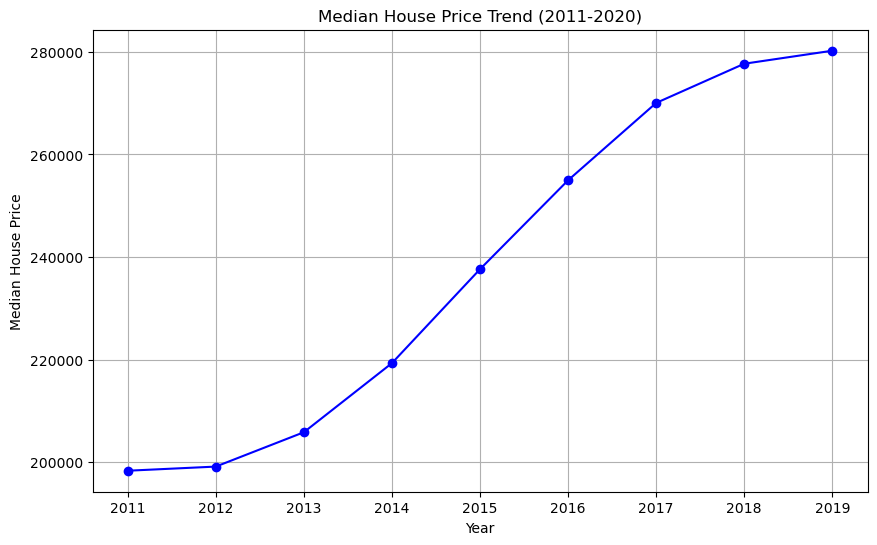

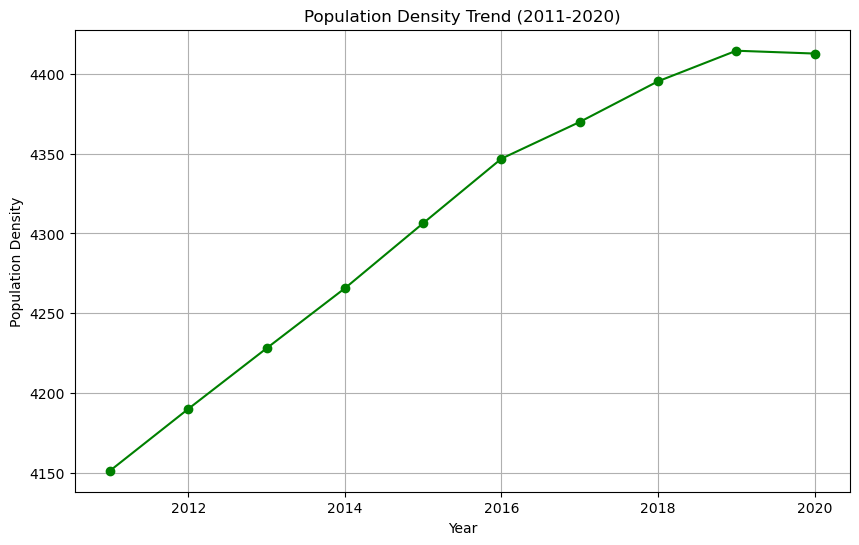

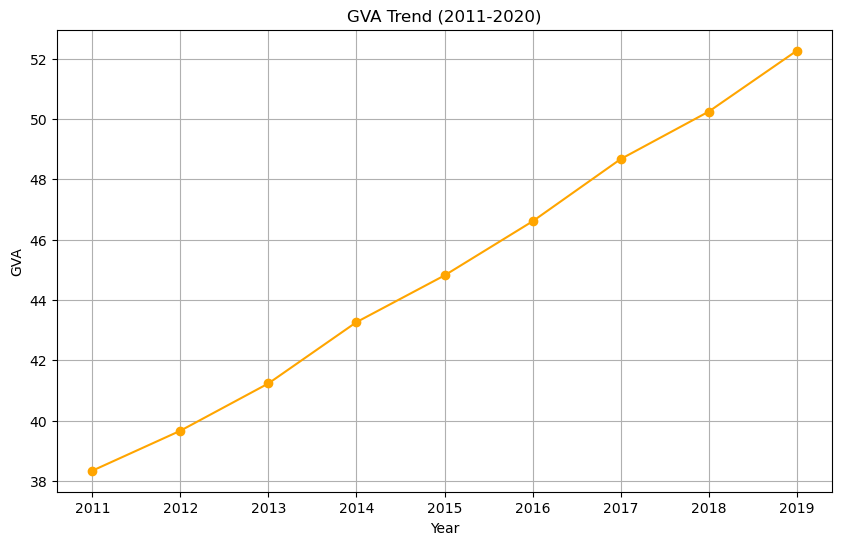

In [22]:
import matplotlib.pyplot as plt

# 1. Median House Price Trend (2011-2020)
plt.figure(figsize=(10, 6))
housing_data.groupby("Year")["Median House Price"].mean().plot(kind="line", marker="o", color="blue")
plt.title("Median House Price Trend (2011-2020)")
plt.xlabel("Year")
plt.ylabel("Median House Price")
plt.grid(True)
plt.show()

# 2. Population Density Trend (2011-2020)
plt.figure(figsize=(10, 6))
population_density_data.groupby("Year")["Population Density"].mean().plot(kind="line", marker="o", color="green")
plt.title("Population Density Trend (2011-2020)")
plt.xlabel("Year")
plt.ylabel("Population Density")
plt.grid(True)
plt.show()

# 3. GVA Trend (2011-2020)
plt.figure(figsize=(10, 6))
gva_data.groupby("Year")["GVA"].mean().plot(kind="line", marker="o", color="orange")
plt.title("GVA Trend (2011-2020)")
plt.xlabel("Year")
plt.ylabel("GVA")
plt.grid(True)
plt.show()


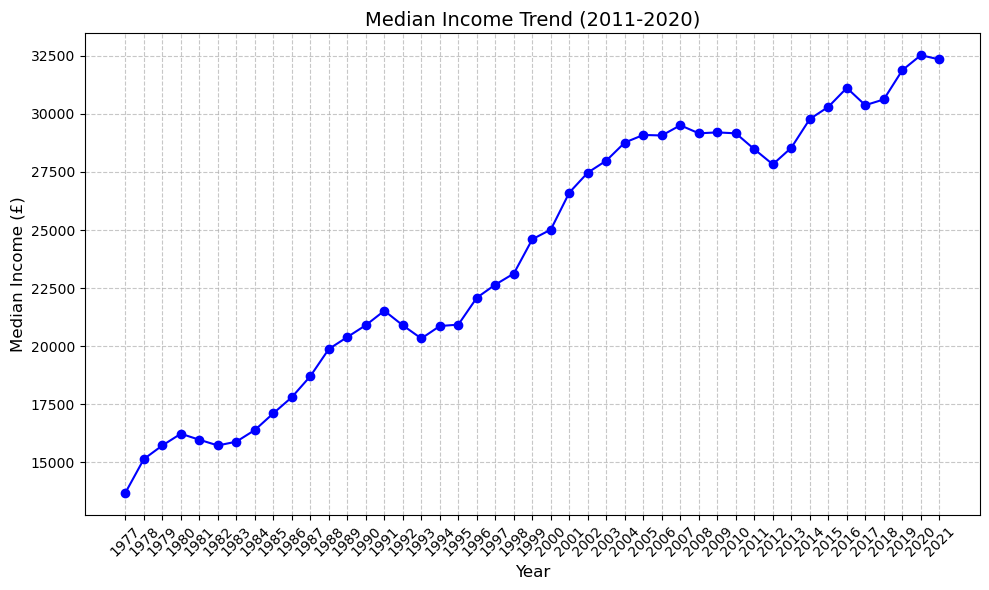

In [23]:
import matplotlib.pyplot as plt


# 绘制折线图
plt.figure(figsize=(10, 6))
plt.plot(income_data["Year"], income_data["Median Income"], marker="o", linestyle="-", color="blue")
plt.title("Median Income Trend (2011-2020)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Median Income (£)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.xticks(income_data["Year"], rotation=45)
plt.tight_layout()
plt.show()


In [24]:
# 假设 travel_time_data 包含 "Average Travel Time" 列
print("Descriptive statistics for Average Travel Time:")
print(travel_time_data["Average Travel Time"].describe())


Descriptive statistics for Average Travel Time:
count    4969.000000
mean       29.870741
std        27.934499
min         0.615284
25%        18.565192
50%        26.798093
75%        35.751836
max       600.000000
Name: Average Travel Time, dtype: float64
